说明：本实验内容是用的经典的数据集MNIST，数据集包含一个用于训练的train.csv和一个用于测试的test.csv。其中，train.csv中包含42000个样本，每个样本为一张手写数字图片，特征维度为784（28 * 28），第一列为标签列；test.csv中包含20000个样本，不包含标签列，只用于预测。

首先，我们尝试使用经典的机器学习算法，来进行预测，看看效果，比如我们熟知的随机森林，SVM，还有简单的朴素贝叶斯，再用用后来的boosting方法的XGBoost和LightGBM。然后，我们再尝试使用基于深度学习的CNN，看看准确率和性能是否有提升。

In [1]:
# 加载数据

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

In [2]:
def loaddata(file, train=True):
    if train:
        data_train = pd.read_csv(file)
        X_train = data_train[data_train.columns[1:785]]
        y_train = data_train['label']
        return X_train, y_train
    else:
        data_test = pd.read_csv(file)
        X_test = data_test
        return X_test

In [3]:
X, y = loaddata('./数据集/train.csv')

In [4]:
X_test = loaddata('./数据集/test.csv', train=False)

In [5]:
y.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

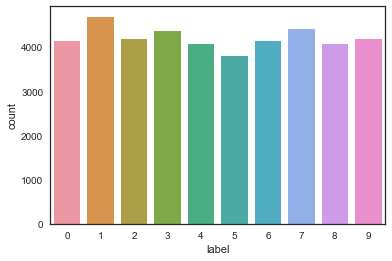

In [6]:
sns.countplot(y) # 样本类别是均匀的

In [7]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

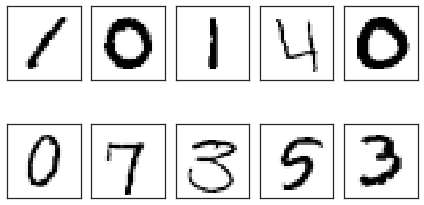

In [8]:
# 数字可视化
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = np.array(X.iloc[i]).reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [9]:
# 训练模型

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist

Using TensorFlow backend.


In [10]:
(Xtrain, ytrain), (Xtest, ytest) = mnist.load_data()
Xtrain = Xtrain.reshape((-1, 28 * 28)) / 255.0
Xtest = Xtest.reshape((-1, 28 * 28)) / 255.0

In [11]:
X_train = np.concatenate((Xtrain, X))
y_train = np.concatenate((ytrain, y))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

In [13]:
mnb = MultinomialNB()
gscv = GridSearchCV(mnb, {'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}, cv=10, n_jobs=-1)
gscv.fit(X_train, y_train)
mnb = MultinomialNB(alpha = gscv.best_params_['alpha'])
mnb.fit(X_train, y_train)
mnb.score(X_val, y_val)

0.8220588235294117

In [ ]:
rf = RandomForestClassifier()
gscv = GridSearchCV(rf, {'n_estimators': [50, 80, 100, 200],
                         'max_depth': [3, 10, 30, 50],
                         'min_samples_split': [2, 5, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'random_state': range(101)}, cv=10, n_jobs=-1)
gscv.fit(X_train, y_train)
rfc = RandomForestClassifier(n_estimators=gscv.best_params_['n_estimators'],
                             max_depth=gscv.best_params_['max_depth'],
                             min_samples_split=gscv.best_params_['min_samples_split'],
                             min_samples_leaf=gscv.best_params_['min_samples_leaf'],
                             random_state=gscv.best_params_['random_state'])
rfc.fit(X_train, y_train)
rfc.score(X_val, y_val)

在此之前，看一下使用全连接DNN，是否跟传统机器学习算法有什么不同？

In [ ]:
from keras import layers, models, utils, callbacks
from keras import datasets

In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(Xtest)

y_train = utils.to_categorical(y_train, num_classes=10)
y_val = utils.to_categorical(y_val, num_classes=10)

In [ ]:
max_val_acc = []
params = []

early_stopping = callbacks.EarlyStopping(patience=50) 

for hidden_size1 in [64, 128, 256, 512]:
    for hidden_size2 in [64, 128, 256, 512]:
        for activation in ['elu', 'selu', 'relu']:
            for epochs in [10, 50, 100, 200]:
                for batch_size in [100, 200, 500, 1000]:
                    model = models.Sequential()
                    model.add(layers.Dense(hidden_size1, activation=activation))
                    model.add(layers.Dense(hidden_size2, activation=activation))
                    model.add(layers.Dense(10, activation='softmax'))

                    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])
                    
                    max_val_acc.append(max(history.history['val_acc']))
                    params.append([hidden_size1, hidden_size2, activation, epochs, batch_size])

In [ ]:
best_params = params[np.argmax(max_val_acc)]

model = models.Sequential()
model.add(layers.Dense(best_params[0], activation=best_params[2]))
model.add(layers.Dense(best_params[1], activation=best_params[2]))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=best_params[3], batch_size=best_params[4], validation_data=(X_val, y_val), callbacks=[early_stopping])

选择使用CNN来验证评估结果是否会有提高。

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [ ]:
max_val_acc = []
params = []

for hidden_size1 in [64, 128, 256, 512]:
    for hidden_size2 in [64, 128, 256, 512]:
        for hidden_size3 in [64, 128, 256, 512]:
            for activation in ['elu', 'selu', 'relu']:
                for window_size in [1, 3, 5]:
                    for pooling_size in [1, 2, 3]:
                        for dropout1 in [0.1, 0.2, 0.3]:
                            for dropout2 in [0.2, 0.3, 0.4]:
                                for dropout3 in [0.5, 0.6, 0.7]:
                                    for epochs in [10, 50, 100, 200]:
                                        for batch_size in [100, 300, 500, 1000]:        
                                            model = models.Sequential()
                                            model.add(layers.Conv2D(hidden_size1, (window_size, window_size), activation='relu'))
                                            model.add(layers.MaxPooling2D((pooling_size, pooling_size)))
                                            model.add(layers.SpatialDropout2D(dropout1))
                                            model.add(layers.Conv2D(hidden_size2, (window_size, window_size), activation='relu'))
                                            model.add(layers.MaxPooling2D((pooling_size, pooling_size)))
                                            model.add(layers.SpatialDropout2D(dropout2))
                                            model.add(layers.Conv2D(hidden_size3, (window_size, window_size), activation='relu'))
                                            model.add(layers.MaxPooling2D((pooling_size, pooling_size)))
                                            model.add(layers.SpatialDropout2D(dropout3))

                                            model.add(layers.Flatten())
                                            model.add(layers.Dense(10, activation='softmax'))

                                            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                                            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])
                                            
                                            max_val_acc.append(max(history.history['val_acc']))
                                            params.append([hidden_size1, hidden_size2, hidden_size3, activation, window_size, pooling_size, dropout1, dropout2, dropout3, epochs, batch_size])

In [ ]:
best_params = params[np.argmax(max_val_acc)]

model = models.Sequential()
model.add(layers.Conv2D(best_params[0], (best_params[4], best_params[4]), activation=best_params[3]))
model.add(layers.MaxPooling2D((best_params[5], best_params[5])))
model.add(layers.SpatialDropout2D(best_params[6]))
model.add(layers.Conv2D(best_params[1], (best_params[4], best_params[4]), activation='relu'))
model.add(layers.MaxPooling2D((best_params[5], best_params[5])))
model.add(layers.SpatialDropout2D(best_params[7]))
model.add(layers.Conv2D(best_params[2], (best_params[4], best_params[4]), activation='relu'))
model.add(layers.MaxPooling2D((best_params[5], best_params[5])))
model.add(layers.SpatialDropout2D(best_params[8]))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=best_params[9], batch_size=best_params[10], validation_data=(X_val, y_val), callbacks=[early_stopping])

In [ ]:
model.summary()

在图像识别的例子中，默认会采用CNN来处理，为防止过拟合采取的步骤有数据增强，使用Dropout机制，和BatchNormalization